# Prédire la projection de films inédits dans les cinémas français

Olivier Viollet, avril 2019, olivier.viollet[a]gmail.com

## Résumé

Cette étude modélise la projection de films inédits dans les cinémas français afin d'être en mesure, pour un cinéma donné, de prédire le nombre de films inédits qui seront projetés pendant une année. En moyenne, les meilleurs modèles commettent environ 27 erreurs par prédiction. 

Plan :

1. Objectif et données
2. Exploration et transformation des données
3. Modélisation du nombre de films inédits
4. Evaluation de la modélisation

## 1. Objectif et données

L'objectif de l'étude est de prédire combien de films inédits seront projetés pendant l'année dans un cinéma à partir des caractéristiques de ce dernier.

Les données concernent l'année 2017 uniquement, dans leur état au 25 mars 2019. Elles ont été mises à disposition sur le site d'ouverture des données publique du ministère de la culture, data.culture.gouv.fr, et sont accessibles à l'adresse suivante : https://data.culture.gouv.fr/explore/dataset/etablissements-cinematographiques/information/

**2046 établissements cinématographiques** sont recensés. La **variable cible** est le nombre de films inédits. Pour la prédire, sont utilisées les **variables explicatives** suivantes :

- la région du cinéma ;
- son département ;
- son adresse ;
- la population de la commune ;
- la tranche démographique de l'unité urbaine ;
- la nature de la commune (commune isolée, commune-centre, etc.) ;
- le nombre d'écrans ;
- le nombre de fauteuils ;
- le nombre de semaines d'activités ;
- le propriétaire ;
- le programmateur ;
- la catégorie Arts et Essai ;
- le genre (fixe ou itinérant) de cinéma ;
- sa nature multiplexe ou non.

A noter que très peu de données sont manquantes, et ne concernent que les variables "adresse" et "nombre de fauteuils".

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

import keras
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras import backend as K

# fonction pour recoder des valeurs
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

Using TensorFlow backend.


In [3]:
cinema = pd.read_csv('etablissements-cinematographiques.csv', encoding = 'utf-8', sep = ';', 
                     usecols = [2,3,6,7,11,12,13,14,15,16,17,18,19,20,21,23])
print(cinema.info())
cinema.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2046 entries, 0 to 2045
Data columns (total 16 columns):
région administrative       2046 non-null object
adresse                     2039 non-null object
population de la commune    2046 non-null float64
DEP                         2046 non-null object
situation géographique      2046 non-null object
écrans                      2046 non-null float64
fauteuils                   2034 non-null float64
semaines d'activité         2046 non-null float64
propriétaire                2046 non-null object
programmateur               2046 non-null object
catégorie Art et Essai      2046 non-null object
label Art et Essai          690 non-null object
genre                       2046 non-null object
multiplexe                  2046 non-null object
zone de la commune          2046 non-null object
nombre de films inédits     2046 non-null float64
dtypes: float64(5), object(11)
memory usage: 255.8+ KB
None


,région administrative,adresse,population de la commune,DEP,situation géographique,écrans,fauteuils,semaines d'activité,propriétaire,programmateur,catégorie Art et Essai,label Art et Essai,genre,multiplexe,zone de la commune,nombre de films inédits
0,GRAND EST,AVENUE DE SAINTIGNON,14437.0,54,unités urbaines de 20 000 à 100 000 habitants,7.0,1330.0,53.0,NC,KINEPOLIS,catégorie D,JPPR,fixe,non,commune-centre,193.0
1,BOURGOGNE / FRANCHE-COMTE,9 RUE PASTEUR,17459.0,39,unités urbaines de 20 000 à 100 000 habitants,3.0,445.0,53.0,SOCIETE DES CINEMAS LONS LE SAUNIER,AGORA CINEMAS,non classé,NaN,fixe,non,commune-centre,132.0
2,OCCITANIE,6 AV MGR SCHOEPFER,13946.0,65,unités urbaines de moins de 20 000 habitants e...,1.0,281.0,31.0,JACALS,NC,non classé,NaN,fixe,non,commune-centre,0.0
3,OCCITANIE,11 AVENUE MARANSIN,13946.0,65,unités urbaines de moins de 20 000 habitants e...,1.0,249.0,50.0,NC,NC,non classé,NaN,fixe,non,commune-centre,8.0
4,PAYS DE LA LOIRE,BOULEVARD PHELIPON,9394.0,85,unités urbaines de moins de 20 000 habitants e...,5.0,766.0,53.0,SOCIETE CINEMATOGRAPHIQUE LUCONNAISE,NC,non classé,NaN,fixe,non,commune isolée,186.0


## 2. Exploration et transformation des données

### Nombre de films inédits

En moyenne, chaque cinéma projette 142 films inédits par an, le maximum s'élevant à 424 tandis que plusieurs cinémas n'en projettent aucun. Dans l'ensemble, seuls quelques cinémas se distinguent par un nombre très élevé de films inédits, ce qui devrait faciliter la modélisation.

count    2046.000000
mean      142.411046
std        68.949198
min         0.000000
25%        95.250000
50%       144.000000
75%       188.000000
max       424.000000
Name: nombre de films inédits, dtype: float64


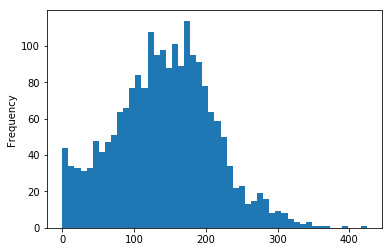

In [4]:
print(cinema['nombre de films inédits'].describe())
cinema['nombre de films inédits'].plot.hist(50)

### Région

Le nombre de films inédits projetés dans les cinémas diffère d'une région à l'autre : faible en Corse, élevé en Bretagne, en Occitanie ou en Nouvelle-Aquitaine.

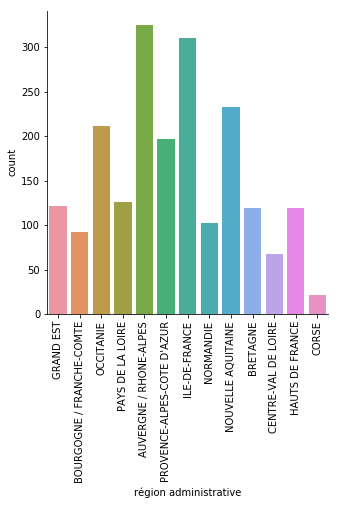

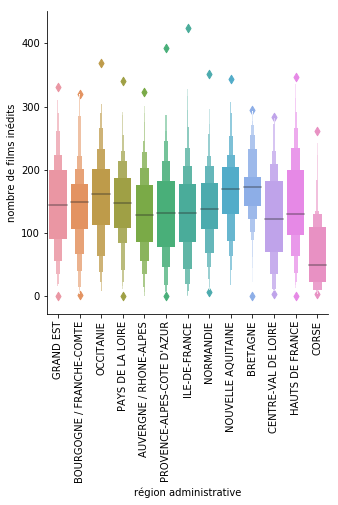

In [5]:
    #région
sns.catplot(x = 'région administrative', kind = 'count', data = cinema).set_xticklabels(rotation=90)
sns.catplot(x = 'région administrative', y ='nombre de films inédits', 
            kind = 'boxen', data = cinema).set_xticklabels(rotation=90)

### Adresse

A partir de l'adresse, il est possible d'extraire les variables suivantes : le cinéma se situe-t-il sur une avenue ? sur un boulevard ? sur une place ? dans une rue ?

L'observation des données laisse néanmoins penser que ces informations se seront pas utiles à la modélisation car ces variables n'apparaissent pas discriminantes. 

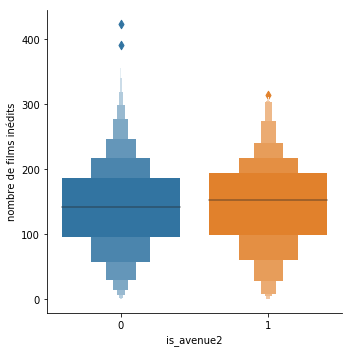

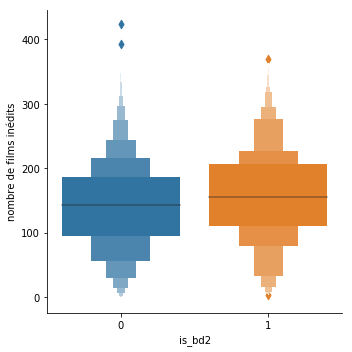

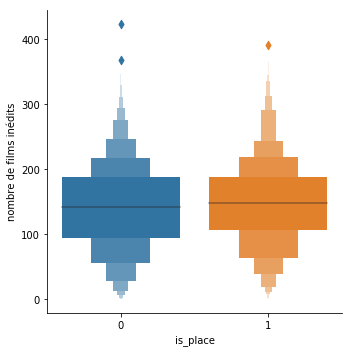

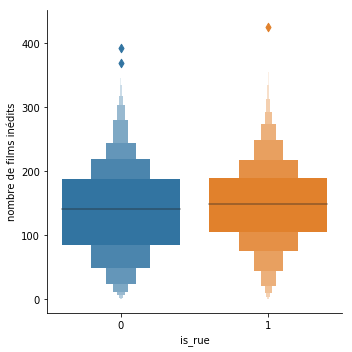

In [6]:
    # adresse
cinema.adresse.fillna('nd', inplace = True)
cinema['is_avenue'] = cinema['adresse'].str.count('AVENUE')
cinema['is_AV'] = cinema['adresse'].str.count('AV ')
cinema['is_avenue2'] = cinema['is_avenue'] + cinema['is_AV']
cinema.drop(columns = ['is_avenue','is_AV'], inplace = True)
sns.catplot(x = 'is_avenue2', y ='nombre de films inédits', kind = 'boxen', data = cinema)

cinema['is_boulevard'] = cinema['adresse'].str.count('BOULEVARD')
cinema['is_BD'] = cinema['adresse'].str.count('BD ')
cinema['is_bd2'] = cinema['is_boulevard'] + cinema['is_BD']
cinema['is_bd2'] = coding(cinema['is_bd2'], {2:1})
cinema.drop(columns = ['is_boulevard','is_BD'], inplace = True)
sns.catplot(x = 'is_bd2', y ='nombre de films inédits', kind = 'boxen', data = cinema)

cinema['is_place'] = cinema['adresse'].str.count('PLACE ')
sns.catplot(x = 'is_place', y ='nombre de films inédits', kind = 'boxen', data = cinema)

cinema['is_rue'] = cinema['adresse'].str.count('RUE ')
cinema['is_rue'] = coding(cinema['is_rue'], {2:1})
sns.catplot(x = 'is_rue', y ='nombre de films inédits', kind = 'boxen', data = cinema)

cinema.drop(columns = ['adresse'], inplace = True)

### Population de la commune

A première vue, le nombre de films inédits ne semble pas fortement corrélé avec la population de la commune du cinéma. De fait, le coefficient de corrélation entre les variables n'est que de +5 %.

Coefficient de corrélation entre la population de la commune et les films inédits :  [[1.         0.05259551]
 [0.05259551 1.        ]]


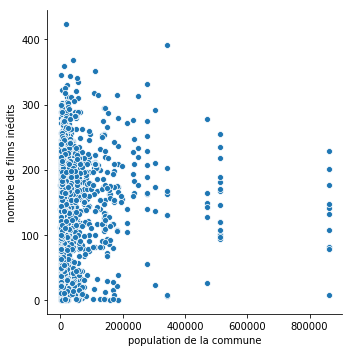

In [7]:
    # population de la commune
sns.relplot(x = 'population de la commune', y = 'nombre de films inédits', data = cinema)
print('Coefficient de corrélation entre la population de la commune et les films inédits : ', 
      np.corrcoef(cinema['population de la commune'], cinema['nombre de films inédits']))

### Département

S'il existe bien entendu des écarts dans le nombre de films inédits par cinéma selon le département, on n'observe néanmoins pas de forte coupure.

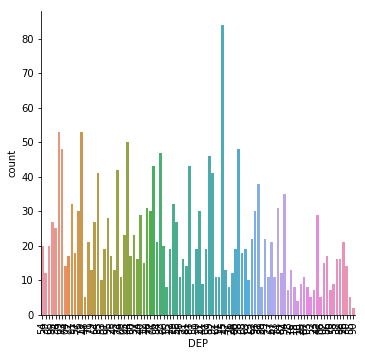

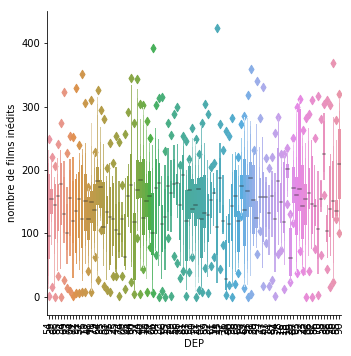

In [8]:
    # DEP
sns.catplot(x = 'DEP', kind = 'count', data = cinema).set_xticklabels(rotation=90)
sns.catplot(x = 'DEP', y ='nombre de films inédits', 
            kind = 'boxen', data = cinema).set_xticklabels(rotation=90)

### Situation géographique

La situation géographique désigne des catégories de territoire d'un point de vue démographique ou géographique. C'est à Paris que les cinémas diffusent le moins de films inédits, au contraire des villes moyennes. 

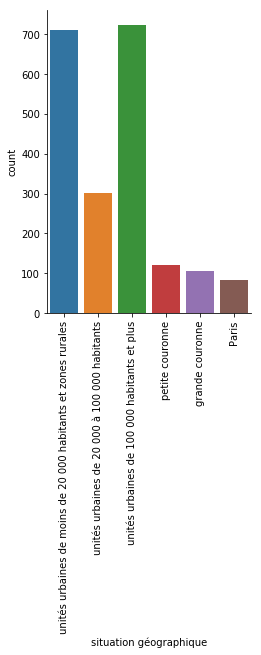

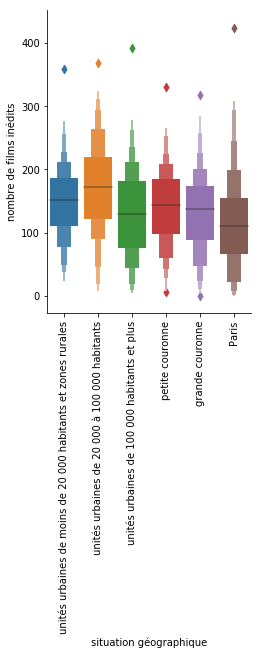

In [9]:
sns.catplot(x = 'situation géographique', order = ['unités urbaines de moins de 20 000 habitants et zones rurales',
                                                   'unités urbaines de 20 000 à 100 000 habitants',
                                                   'unités urbaines de 100 000 habitants et plus',
                                                   'petite couronne','grande couronne',
                                                   'Paris'], 
            kind = 'count', data = cinema).set_xticklabels(rotation=90)
sns.catplot(x = 'situation géographique', order = ['unités urbaines de moins de 20 000 habitants et zones rurales',
                                                   'unités urbaines de 20 000 à 100 000 habitants',
                                                   'unités urbaines de 100 000 habitants et plus',
                                                   'petite couronne','grande couronne',
                                                   'Paris'],
            y ='nombre de films inédits', 
            kind = 'boxen', data = cinema).set_xticklabels(rotation=90)

### Nombre d'écrans

Il existe une corrélation positive assez forte (+47 %) entre le nombre d'écrans du cinéma et le nombre de films inédits qu'il projette.

Coefficient de corrélation entre le nombre d'écrans et les films inédits :  [[1.         0.46922004]
 [0.46922004 1.        ]]


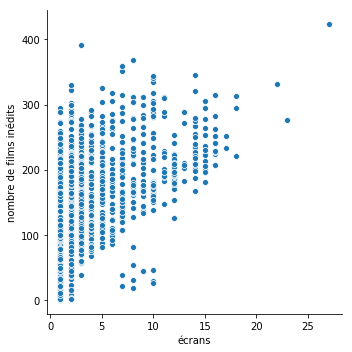

In [10]:
    # écrans
print('Coefficient de corrélation entre le nombre d\'écrans et les films inédits : ', 
      np.corrcoef(cinema['écrans'], cinema['nombre de films inédits']))
sns.relplot(x = 'écrans', y = 'nombre de films inédits', data = cinema)

### Nombre de fauteuils

On observe une corrélation positive relativement forte (+40 %) entre le nombre de fauteuils du cinéma et le nombre de films inédits qu'il projette.

count    2034.000000
mean      549.962635
std       705.729895
min         0.000000
25%       189.000000
50%       287.000000
75%       528.750000
max      7408.000000
Name: fauteuils, dtype: float64
Coefficient de corrélation entre le nombre de fauteuils et les films inédits :  [[1.         0.40121073]
 [0.40121073 1.        ]]


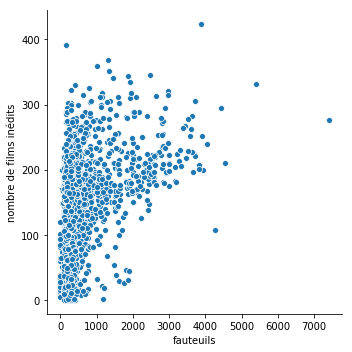

In [11]:
    # fauteuils 
print(cinema.fauteuils.describe())
cinema.fauteuils.fillna(287, inplace = True) # imputer la médiane
print('Coefficient de corrélation entre le nombre de fauteuils et les films inédits : ', 
      np.corrcoef(cinema['fauteuils'], cinema['nombre de films inédits']))
sns.relplot(x = 'fauteuils', y = 'nombre de films inédits', data = cinema)

### Nombre de semaines d'activité

Il existe une forte corrélation positive (+60 %) entre le nombre de semaines d'activité du cinéma et le nombre de films inédits qu'il projette.

Coefficient de corrélation entre le nombre de semaines d'activité et les films inédits :  [[1.         0.60285446]
 [0.60285446 1.        ]]


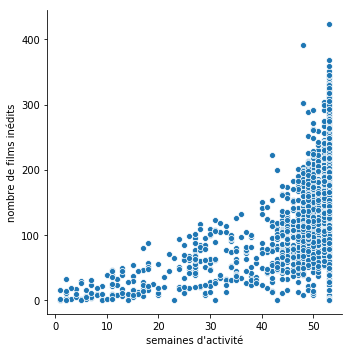

In [12]:
    # semaines d'activité
print('Coefficient de corrélation entre le nombre de semaines d\'activité et les films inédits : ', 
      np.corrcoef(cinema['semaines d\'activité'], cinema['nombre de films inédits']))
sns.relplot(x = 'semaines d\'activité', y = 'nombre de films inédits', data = cinema)

### Propriétaire de l'établissement

Compte tenu du grand nombre de propriétaires possibles pour les établissements, la variable est retravaillée afin d'extraire les seuls propriétaires suivants :

- Gaumont ;
- UGC ;
- une association ;
- une municipalité.

Il apparait que le nombre de films inédits est sensiblement plus élevé dans les cinémas Gaumont ou UGC que les autres, mais qu'il est équivalent voire légèrement inférieur dans les cinémas détenus par des associations ou des mairies que dans les autres établissements. 

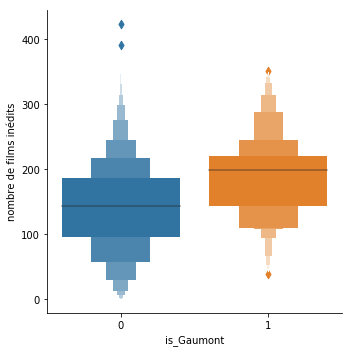

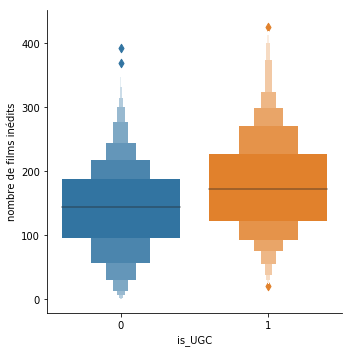

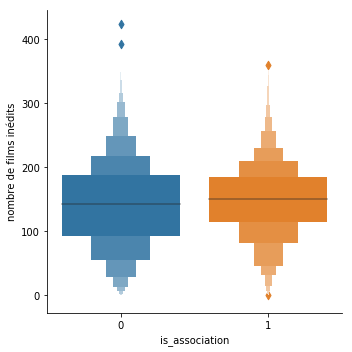

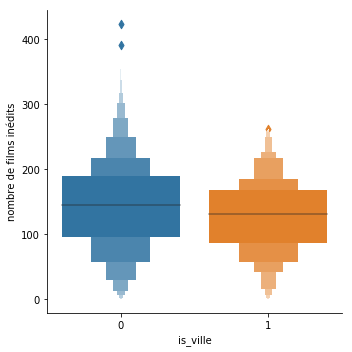

In [13]:
    # propriétaire
cinema['is_Gaumont'] = cinema['propriétaire'].str.count('GAUMONT')
sns.catplot(x = 'is_Gaumont', y ='nombre de films inédits', kind = 'boxen', data = cinema)

cinema['is_UGC'] = cinema['propriétaire'].str.count('UGC')
sns.catplot(x = 'is_UGC', y ='nombre de films inédits', kind = 'boxen', data = cinema)

cinema['is_association'] = cinema['propriétaire'].str.count('ASSOCIATION')
cinema['is_association'] = coding(cinema['is_association'], {2:1})
sns.catplot(x = 'is_association', y ='nombre de films inédits', kind = 'boxen', data = cinema)

cinema['is_ville'] = cinema['propriétaire'].str.count('VILLE ')
cinema['is_ville'] = coding(cinema['is_ville'], {2:1})
sns.catplot(x = 'is_ville', y ='nombre de films inédits', kind = 'boxen', data = cinema)

cinema.drop(columns = ['propriétaire'], inplace = True)

### Programmateur

Le grand nombre de programmateur nous conduit à réduire les modalités possibles pour ne conserver que que les occurrences les plus fréquentes, tandis que les autres sont fusionnées en une seule catégorie. Il apparait que le nombre de films inédits projetés diffère légèrement selon le programmateur.

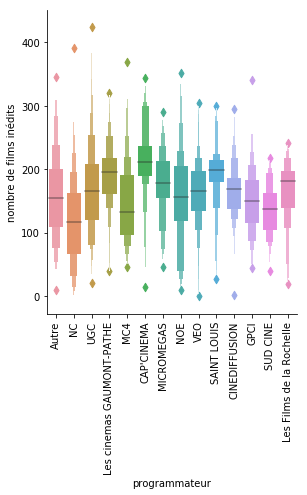

In [14]:
cinema['programmateur'] = coding(cinema['programmateur'], {'UGC Mediterranée':'UGC'})
series = pd.value_counts(cinema.programmateur)
mask = (series/series.sum() * 100).lt(1)  # ici, niveau = 1 %
cinema['programmateur'] = np.where(cinema['programmateur'].isin(series[mask].index),
                                   'Autre',cinema['programmateur'])
sns.catplot(x = 'programmateur', y ='nombre de films inédits', 
            kind = 'boxen', data = cinema).set_xticklabels(rotation=90)

### Catégorie Art et Essai

Les cinémas qui ne sont pas classés Art et Essai sont ceux qui diffusent en général le moins de films inédits, suivis par les cinémas de catégorie A et B, tandis que ceux de catégorie D en projettent bien davantage. 

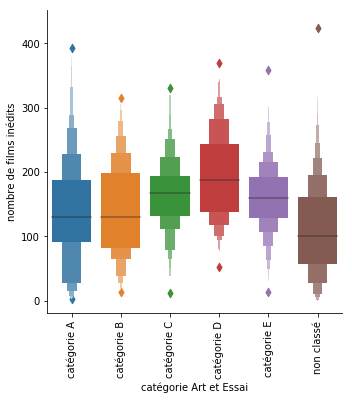

In [15]:
    # catégorie Art et Essai
sns.catplot(x = 'catégorie Art et Essai', 
            order = ['catégorie A','catégorie B','catégorie C','catégorie D','catégorie E','non classé'], 
            y ='nombre de films inédits', 
            kind = 'boxen', data = cinema).set_xticklabels(rotation=90)

### Label Art et Essai

Les cinémas non labellisés ainsi que les cinémas détenteurs du label RDPR comptent parmi ceux diffusant le moins de films inédits.

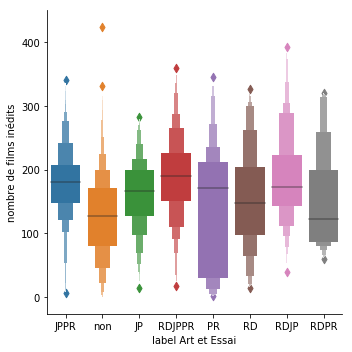

In [16]:
    # label Art et Essai
cinema['label Art et Essai'].fillna('non', inplace = True)
sns.catplot(x = 'label Art et Essai', y ='nombre de films inédits', 
            kind = 'boxen', data = cinema)

### Genre de cinéma

Les cinémas itinérants diffusent beaucoup moins de films inédits que les cinémas établis fixement. 

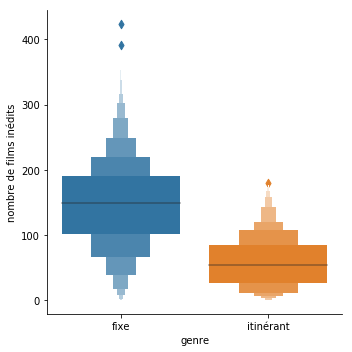

In [17]:
    # genre
sns.catplot(x = 'genre', y ='nombre de films inédits', kind = 'boxen', data = cinema)

### Multiplexe

Les cinémas multiplexes tendent à projeter bien plus de films inédits que les non-multiplexes.

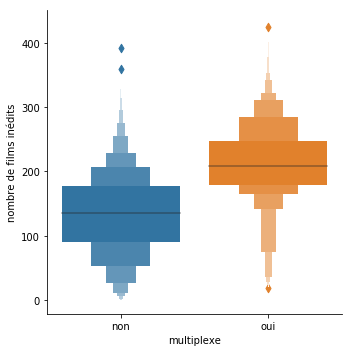

In [18]:
    # multiplexe
sns.catplot(x = 'multiplexe', y ='nombre de films inédits', kind = 'boxen', data = cinema)

### Zone de la commune

Ce sont les établissements des territoires ruraux qui semblent projeter moins de films inédits que les autres types de zone, lesquels se situent à des niveaux comparables. 

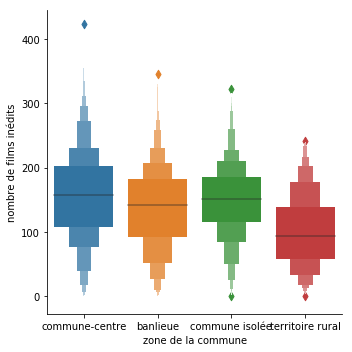

In [19]:
    # zone de la commune
sns.catplot(x = 'zone de la commune', 
            order = ['commune-centre','banlieue','commune isolée','territoire rural'], 
            y ='nombre de films inédits', kind = 'boxen', data = cinema)

In [20]:
cinema.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2046 entries, 0 to 2045
Data columns (total 22 columns):
région administrative       2046 non-null object
population de la commune    2046 non-null float64
DEP                         2046 non-null object
situation géographique      2046 non-null object
écrans                      2046 non-null float64
fauteuils                   2046 non-null float64
semaines d'activité         2046 non-null float64
programmateur               2046 non-null object
catégorie Art et Essai      2046 non-null object
label Art et Essai          2046 non-null object
genre                       2046 non-null object
multiplexe                  2046 non-null object
zone de la commune          2046 non-null object
nombre de films inédits     2046 non-null float64
is_avenue2                  2046 non-null int64
is_bd2                      2046 non-null int64
is_place                    2046 non-null int64
is_rue                      2046 non-null int64
is_Gaumont

## 3. Modéliser le nombre de films inédits diffusés dans les cinémas

Le problème relève de la régression puisque la variable à prédire - le nombre de films inédits - est continue. La mesure de performance choisie est l'**erreur moyenne absolue**, qui devrait bien synthétiser la marge d'erreur des modèles en raison du petit nombre de valeurs extrêmes.

Des variables binaires sont créées à partir des variables discrète. Le jeu de données principal est ensuite coupé en trois morceaux. Dans un premier temps, sont distingués un jeu d'entrainement et un jeu de test. Dans un second temps, le jeu d'entrainement est lui-même coupé en un jeu d'entrainement et un jeu de validation. Les modèles sont entrainés sur ce dernier jeu d'entrainement, puis leurs hyperparamètres sont évalués et ajustés sur le jeu de validation. 

A noter que les valeurs des variables explicatives sont centrées et réduites dans un intervalle compris entre 0 et 1.

In [21]:
# préparer les jeux d'entrainement et de test
Target = cinema['nombre de films inédits']
cinema.drop(columns = ['nombre de films inédits'], inplace=True)

# créer les variables binaires
predictors = pd.get_dummies(cinema)

# créer les jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(predictors, Target, 
                                                    test_size=0.2, random_state=15)

# créer les jeux d'entrainement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, random_state=42)

# normaliser 
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(X_train)
X_train_preprocess = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_preprocess, columns = X_train.columns)
del X_train_preprocess
X_val_preprocess = scaler.transform(X_val)
X_val = pd.DataFrame(X_val_preprocess, columns = X_val.columns)
del X_val_preprocess

C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Régression linéaire

La **régression linéaire** réalise ses prédictions avec une erreur moyenne de **28** films inédits. Prendre le logarithme naturel de la variable à prédire détériorerait le résultat.

In [22]:
# régression linéaire
reg = LinearRegression().fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
print("Erreur moyenne sur le jeu d\'entrainement : ", 
      mean_absolute_error(y_train, y_train_pred)) # 27.3

y_val_pred = reg.predict(X_val)
y_val_pred = pd.DataFrame(y_val_pred)
y_val_pred.describe()
y_val_pred.rename(columns = {0:'predictions'}, inplace = True)
y_val_pred.loc[y_val_pred['predictions'] < 0, 'predictions'] = 0
print('Erreur moyenne sur le jeu de validation : ', 
      mean_absolute_error(y_val, y_val_pred)) # 28.1

Erreur moyenne sur le jeu d'entrainement :  27.293879424395545
Erreur moyenne sur le jeu de validation :  28.108266690882243


In [23]:
    # logarithme naturel 
y_train_log = y_train + 0.1 
y_train_log = np.log(y_train_log)
reg_log = LinearRegression().fit(X_train, y_train_log)
y_train_pred = reg_log.predict(X_train)
print("Erreur moyenne sur le jeu d\'entrainement : ", 
      mean_absolute_error(y_train, np.exp(y_train_pred))) # 34.1

y_val_pred = reg_log.predict(X_val)
print('Erreur moyenne sur le jeu de validation : ', 
      mean_absolute_error(y_val, np.exp(y_val_pred))) # 39.3

Erreur moyenne sur le jeu d'entrainement :  34.12553494692189
Erreur moyenne sur le jeu de validation :  39.34752340267143


### Forêt aléatoire

Régularisée afin de réduire le sur-apprentissage, la **forêt aléatoire** obtient un meilleur résultat global avec une erreur moyenne d'environ **26** films inédits.

In [24]:
# forêt aléatoire
forest = RandomForestRegressor(criterion = 'mae',random_state = 1, n_jobs = -1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_val_pred = forest.predict(X_val)

print("Erreur moyenne sur le jeu d\'entrainement : ", 
      mean_absolute_error(y_train, y_train_pred)) # 11.4
print('Erreur moyenne sur le jeu de validation : ', 
      mean_absolute_error(y_val, y_val_pred)) # 28.4

Erreur moyenne sur le jeu d'entrainement :  11.433944954128439
Erreur moyenne sur le jeu de validation :  28.40670731707317


In [25]:
forest = RandomForestRegressor(criterion = 'mae',random_state = 1, n_jobs = -1, max_depth = 12, min_samples_split=25)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_val_pred = forest.predict(X_val)

print("Erreur moyenne sur le jeu d\'entrainement : ", 
      mean_absolute_error(y_train, y_train_pred)) # 22.5
print('Erreur moyenne sur le jeu de validation : ', 
      mean_absolute_error(y_val, y_val_pred)) # 26.5

Erreur moyenne sur le jeu d'entrainement :  22.46544342507645
Erreur moyenne sur le jeu de validation :  26.514329268292684


### Light GBM

Le ***gradient boosting machine***, ici dans sa version *light*, et après régularisation, parvient à un résultat intermédiaire entre la régression linéaire et la forêt aléatoire, avec une erreur moyenne de **27** films inédits.

In [26]:
# light GBM 
y_train = pd.DataFrame(y_train)

params = {"objective" : "regression",
          "metric" : "mae",
          'boosting_type' : 'gbdt',
          "num_leaves" : 30,
          "min_child_weight" : 50,
          "learning_rate" : 0.1,
          "bagging_fraction" : 0.7,
          "feature_fraction" : 0.7,
          "bagging_seed" : 420,
          "verbosity" : -1}

d_train = lgb.Dataset(X_train, label = y_train["nombre de films inédits"])

clf = lgb.train(params, d_train, 100)
y_train_pred = clf.predict(X_train)
print("Erreur moyenne sur le jeu d\'entrainement : ", 
      mean_absolute_error(y_train, y_train_pred)) # 21.5

y_val_pred = clf.predict(X_val)
print('Erreur moyenne sur le jeu de validation : ',
      mean_absolute_error(y_val, y_val_pred)) # 27.1

Erreur moyenne sur le jeu d'entrainement :  21.55533003671413
Erreur moyenne sur le jeu de validation :  27.159370649837523


### Réseau de neurones

L'erreur moyenne réalisée par le **réseau de neurones** apparait pire que celle d'une simple régression linéaire, avec des prédictions à plus de **28** films inédits près.  

In [27]:
model = Sequential()
model.add(Dense(32, activation='relu',input_shape=(X_train.shape[1],), kernel_initializer='uniform'))
model.add(Dense(32, activation='relu')) 
model.add(Dense(1, activation='linear'))
Adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = Adam, loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs = 30, verbose=1, validation_data = (X_val, y_val))

Train on 1308 samples, validate on 328 samples
Epoch 1/30
1308/1308 [==============================] - 1s 609us/step - loss: 19380.7337 - mean_absolute_error: 120.7386 - val_loss: 6998.2601 - val_mean_absolute_error: 69.0984
Epoch 2/30
1308/1308 [==============================] - 0s 24us/step - loss: 4617.8586 - mean_absolute_error: 54.0615 - val_loss: 3046.3830 - val_mean_absolute_error: 44.3450
Epoch 3/30
1308/1308 [==============================] - 0s 24us/step - loss: 3027.8406 - mean_absolute_error: 42.9840 - val_loss: 2321.5209 - val_mean_absolute_error: 38.5051
Epoch 4/30
1308/1308 [==============================] - 0s 24us/step - loss: 2413.9783 - mean_absolute_error: 38.1568 - val_loss: 1949.1178 - val_mean_absolute_error: 34.7206
Epoch 5/30
1308/1308 [==============================] - 0s 24us/step - loss: 2112.7940 - mean_absolute_error: 35.2650 - val_loss: 1782.6935 - val_mean_absolute_error: 32.7389
Epoch 6/30
1308/1308 [==============================] - 0s 24us/step - loss

### Prédire la moyenne

Les performances des modèles ci-dessus peuvent être comparées au score qu'obtiendrait une technique simple, consistant à prédire la moyenne du jeu d'entrainement (en l'occurrence, 141 films inédits) pour chacun des cinémas du jeu de validation. L'erreur moyenne serait alors de **53** films inédits : ainsi, les algorithmes permettent de diviser par deux l'erreur que cette technique simple induirait. 

In [28]:
# Prédire la moyenne
print(y_train.describe()) # 141
y_val = pd.DataFrame(y_val)
y_val['predictions'] =  141
error = y_val['predictions'] - y_val['nombre de films inédits']
error = np.abs(error)
print(error.describe()) # erreur moyenne = 53.3

       nombre de films inédits
count              1308.000000
mean                141.603976
std                  70.304784
min                   0.000000
25%                  93.000000
50%                 143.000000
75%                 187.000000
max                 424.000000
count    328.000000
mean      53.329268
std       39.639215
min        0.000000
25%       21.000000
50%       46.000000
75%       75.000000
max      199.000000
dtype: float64


## 4. Evaluer la qualité de la modélisation

Les modèles ont été entrainés et leurs hyperparamètres ajustés sur un jeu de données dit d'entrainement, comprenant en son sein un jeu de validation. Désormais, il convient de recréer les jeux de données d'entrainement et de test, de centrer et réduire leurs valeurs, puis d'entrainer une dernière fois les modèles sur le jeu d'entrainement complet, c'est-à-dire intégrant le jeu qui avait été utilisé pour la validation, et d'évaluer leurs performances sur le jeu de test. 

Les performance des différents modèles, à l'instar de celles obtenues précédemment sur le jeu de validation, sont très proches, la meilleure étant, de peu, celle du *gradient boosting machine*, avec une erreur moyenne d'environ **27** films inédits par prédiction.

A noter que les algorithmes divergent dans l'importance accordée aux variables explicatives pour réaliser leurs prédictions : en particulier, si la forêt aléatoire recourt très fortement au nombre de semaines d'activités du cinéma, le *light GBM* privilégie de son côté, avant cette variable, la population de la commune et le nombre de fauteuils.

In [29]:
# recréer les jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(predictors, Target, 
                                                    test_size=0.2, random_state=15)

# normaliser 
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(X_train)
X_train_preprocess = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_preprocess, columns = X_train.columns)
del X_train_preprocess
X_test_preprocess = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_preprocess, columns = X_test.columns)
del X_test_preprocess

C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Régression linéaire

In [30]:
# régression linéaire
reg = LinearRegression().fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train, y_train_pred)) # 27.1

y_test_pred = reg.predict(X_test)
y_test_pred = pd.DataFrame(y_test_pred)
y_test_pred.describe()
y_test_pred.rename(columns = {0:'predictions'}, inplace = True)
y_test_pred.loc[y_test_pred['predictions'] < 0, 'predictions'] = 0
print('Erreur moyenne sur le jeu de test : ', 
      mean_absolute_error(y_test, y_test_pred)) # 29.0

Erreur moyenne sur le jeu d'entrainement :  27.084629049511
Erreur moyenne sur le jeu de test :  29.001076600609757


### Forêt aléatoire

In [31]:
# forêt aléatoire
forest = RandomForestRegressor(criterion = 'mae',random_state = 1, n_jobs = -1, max_depth = 12, min_samples_split=25)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print("Erreur moyenne sur le jeu d\'entrainement : ", 
      mean_absolute_error(y_train, y_train_pred)) # 21.7
print('Erreur moyenne sur le jeu de test : ', 
      mean_absolute_error(y_test, y_test_pred)) # 27.9

Erreur moyenne sur le jeu d'entrainement :  21.721760391198046
Erreur moyenne sur le jeu de test :  27.92475609756098


In [32]:
# importance des variables
pd.DataFrame({'Variable':pd.DataFrame(X_test).columns,
              'Importance':forest.feature_importances_}).sort_values('Importance', 
                                                                     ascending=False)

,Variable,Importance
3,semaines d'activité,0.409736
1,écrans,0.108273
146,catégorie Art et Essai_non classé,0.087830
2,fauteuils,0.076934
154,label Art et Essai_non,0.036976
0,population de la commune,0.036125
135,programmateur_NC,0.020915
100,DEP_75,0.017169
155,genre_fixe,0.014777
121,situation géographique_Paris,0.010370


### Light GBM

In [33]:
# light GBM 
y_train = pd.DataFrame(y_train)

params = {"objective" : "regression",
          "metric" : "mae",
          'boosting_type' : 'gbdt',
          "num_leaves" : 30,
          "min_child_weight" : 50,
          "learning_rate" : 0.1,
          "bagging_fraction" : 0.7,
          "feature_fraction" : 0.7,
          "bagging_seed" : 420,
          "verbosity" : -1}

d_train = lgb.Dataset(X_train, label = y_train["nombre de films inédits"])

clf = lgb.train(params, d_train, 100)
y_train_pred = clf.predict(X_train)
print("Erreur moyenne sur le jeu d\'entrainement : ", 
      mean_absolute_error(y_train, y_train_pred)) # 20.5

y_test_pred = clf.predict(X_test)
print('Erreur moyenne sur le jeu de test : ', 
      mean_absolute_error(y_test, y_test_pred)) # 27.6

Erreur moyenne sur le jeu d'entrainement :  20.529240128417083
Erreur moyenne sur le jeu de test :  27.597758443174932


In [34]:
# importance des variables
pd.DataFrame(sorted(zip(clf.feature_importance(),X_test.columns)), 
             columns=['Value','Feature']).sort_values('Value', ascending=False)

,Value,Feature
162,571,population de la commune
161,507,fauteuils
160,208,semaines d'activité
159,149,écrans
158,87,is_rue
157,76,programmateur_NC
156,61,catégorie Art et Essai_non classé
155,59,zone de la commune_commune-centre
154,55,label Art et Essai_non
153,39,situation géographique_unités urbaines de 100 ...


### Réseau de neurones

In [35]:
# réseau profond de neurones
model = Sequential()
model.add(Dense(32, activation='relu',input_shape=(X_train.shape[1],), kernel_initializer='uniform'))
model.add(Dense(32, activation='relu')) 
model.add(Dense(1, activation='linear'))
Adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = Adam, loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs = 30, verbose=1)

Epoch 1/30
1636/1636 [==============================] - 0s 124us/step - loss: 16949.6076 - mean_absolute_error: 110.5145
Epoch 2/30
1636/1636 [==============================] - 0s 19us/step - loss: 3687.0595 - mean_absolute_error: 48.1884
Epoch 3/30
1636/1636 [==============================] - 0s 29us/step - loss: 2528.8152 - mean_absolute_error: 39.2082
Epoch 4/30
1636/1636 [==============================] - 0s 19us/step - loss: 2078.4243 - mean_absolute_error: 34.9628
Epoch 5/30
1636/1636 [==============================] - 0s 19us/step - loss: 1899.1188 - mean_absolute_error: 33.1020
Epoch 6/30
1636/1636 [==============================] - 0s 19us/step - loss: 1819.3982 - mean_absolute_error: 32.4130
Epoch 7/30
1636/1636 [==============================] - 0s 19us/step - loss: 1763.2489 - mean_absolute_error: 31.9241
Epoch 8/30
1636/1636 [==============================] - 0s 19us/step - loss: 1705.0116 - mean_absolute_error: 31.3259
Epoch 9/30
1636/1636 [==============================]

In [36]:
y_test_pred = model.predict(X_test)
print('Erreur moyenne sur le jeu de test : ', mean_absolute_error(y_test, y_test_pred)) # 29.9

Erreur moyenne sur le jeu de test :  29.95268036098015
